# Реалистичная генерация данных для обратной задачи ЭЭГ


Этот ноутбук демонстрирует создание реалистичных EEG данных с:

- Датчиками на сферической поверхности (имитация EEG шапочки)

- Множественными источниками сигнала с временными пиками

- Пространственно-временной корреляцией сигналов

- Интеграцией с решателем обратной задачи

In [1]:
import os
os.environ['JULIA_NUM_THREADS'] = '1'
os.environ['JULIA_GC_MARK_SWEEP'] = '1'  # Более консервативный GC

In [2]:
# Импорт необходимых библиотек

import sys
sys.path.append('../src')
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Импорт наших модулей
from inverse_npde.eeg_data_generator import (
    EEGDataGenerator, 
    create_eeg_experiment

)
from inverse_npde.julia_interface import EEGInverseSolver, PMLConfig

print("✓ Все модули успешно загружены")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython
✓ Все модули успешно загружены


🧠 Создание реалистичного EEG эксперимента...
🧠 Создание EEG эксперимента для головы adult...
📊 Параметры сигнала: 30 Гц × 1 сек
📊 Параметры сигнала: 30 Гц × 1 сек = 30 отсчетов
Добавлен источник в позиции [-3.0, 2.0, 1.0]
Добавлен источник в позиции [3.0, -1.0, 2.0]
Сгенерировано 960 измеренных точек для головы adult
Визуализация датчиков сохранена: figures/eeg_sensors_adult.png


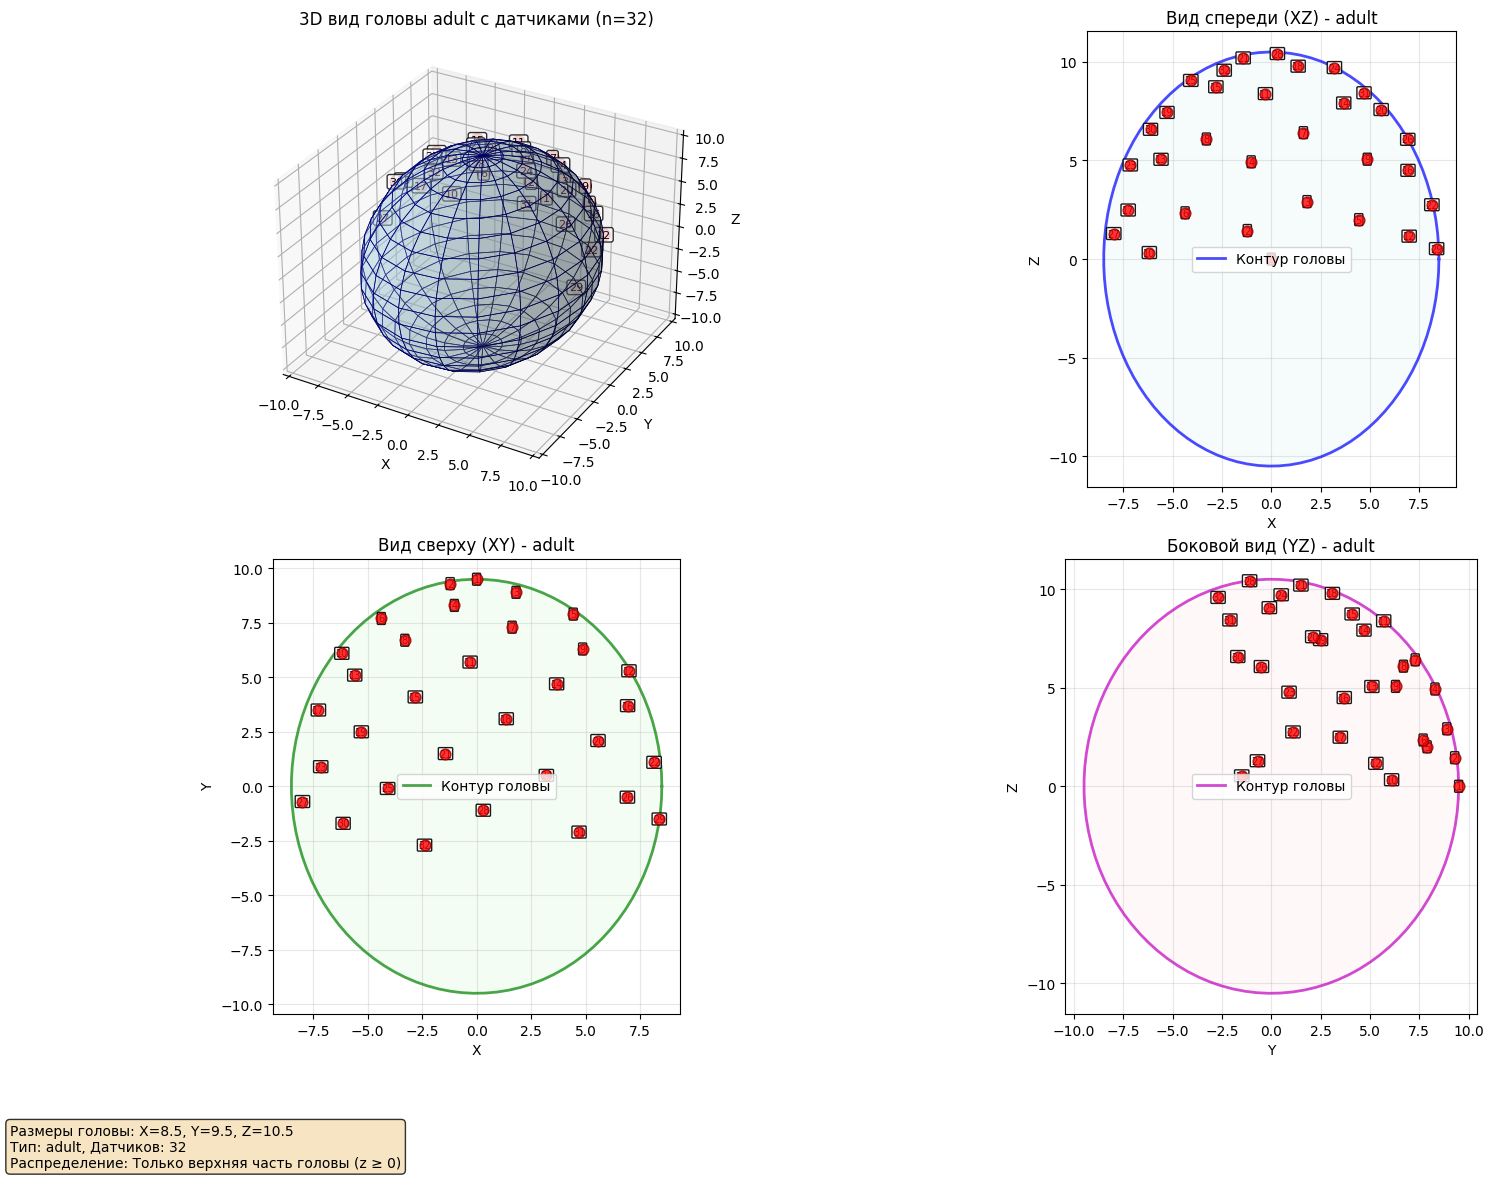

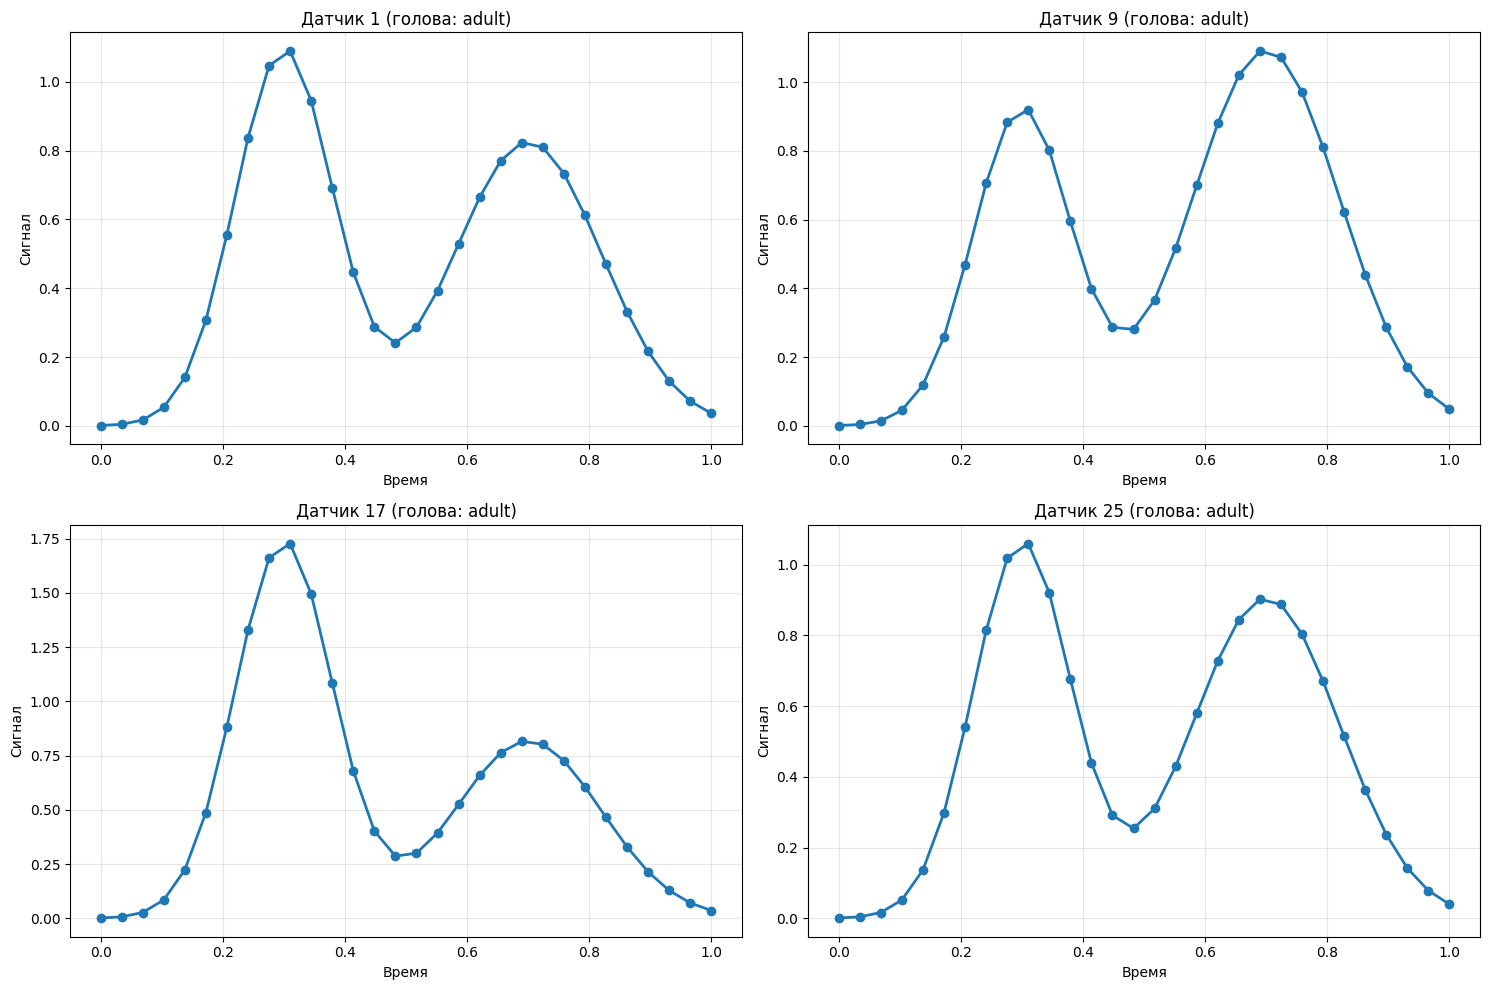

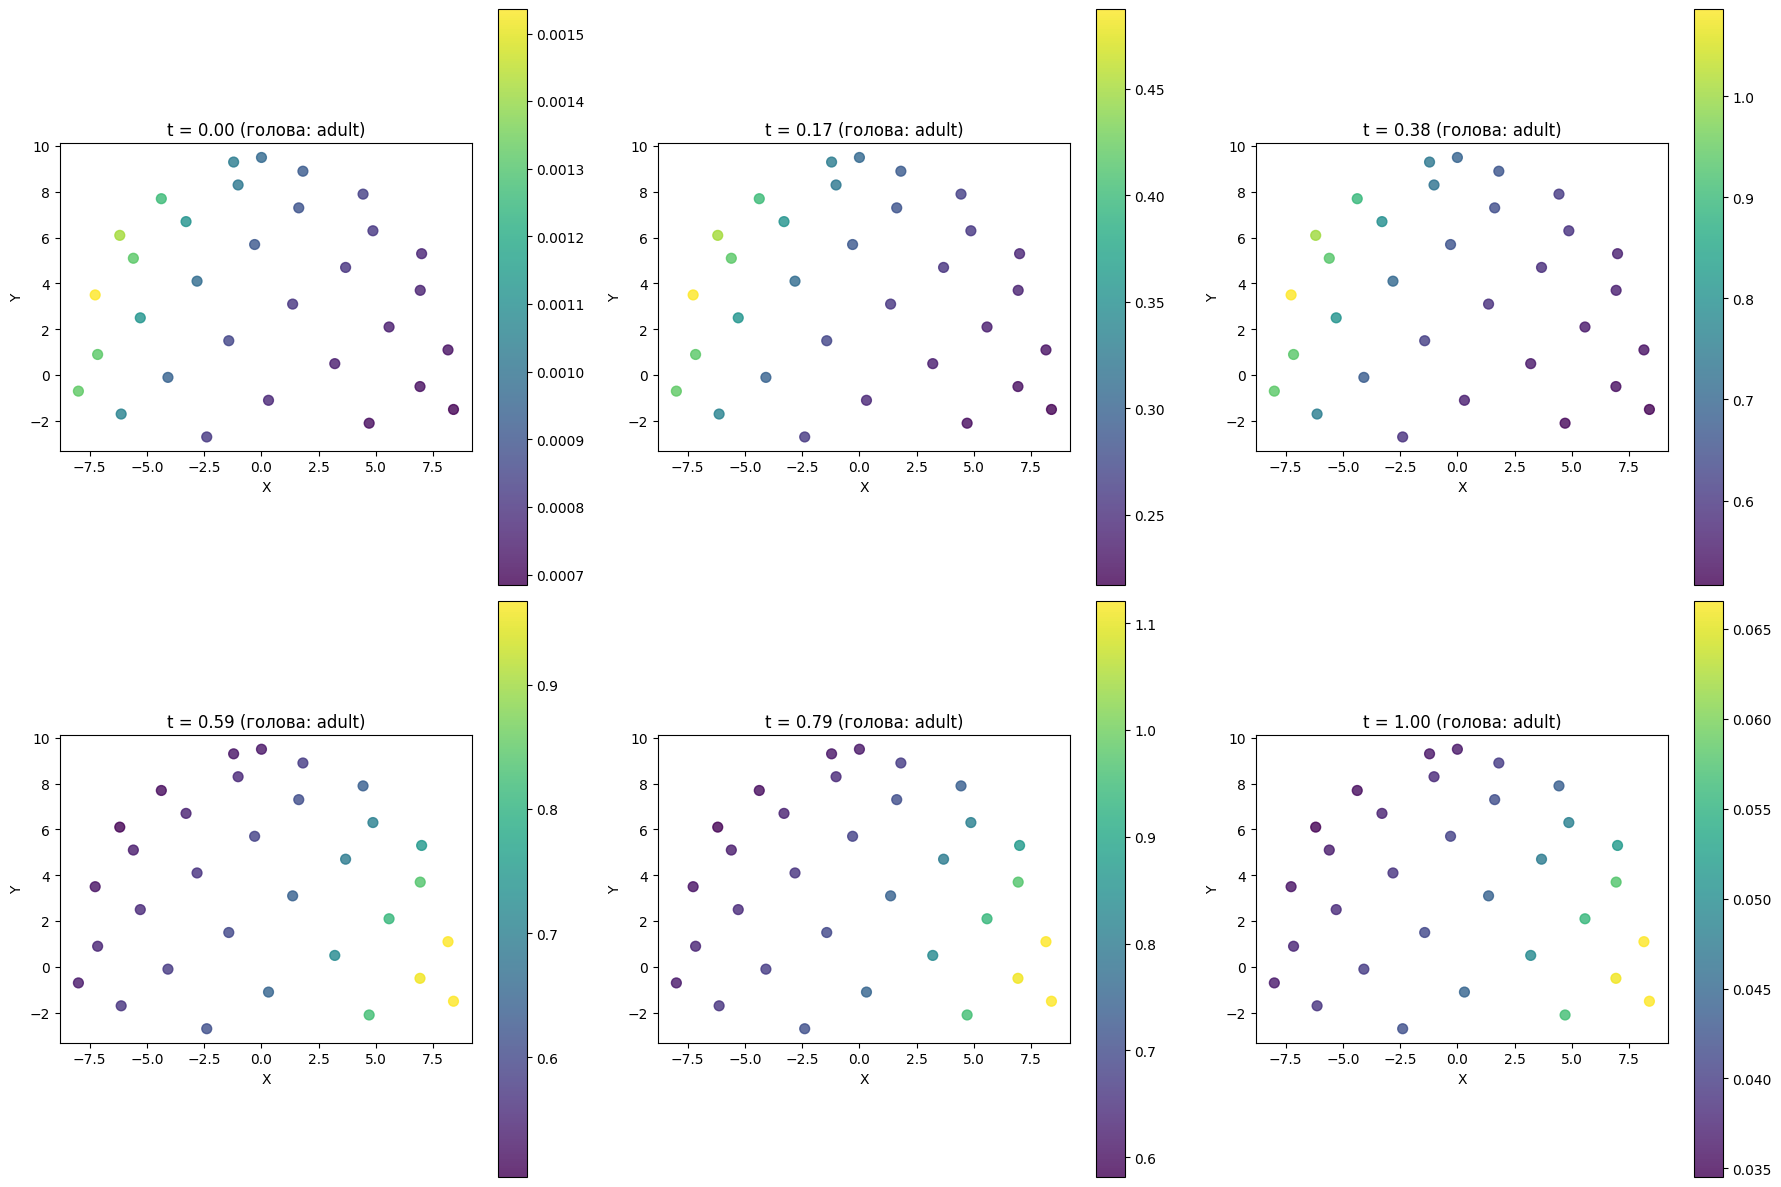

Визуализация сохранена в figures
✅ EEG эксперимент для головы adult создан!
📊 Сгенерировано 960 измеренных точек
📍 Количество датчиков: 32
⏰ Временных точек: 30
⚡ Источников сигнала: 2


In [3]:
## Шаг 1: Создание реалистичного EEG эксперимента
# Создаем EEG эксперимент с реалистичными параметрами
n_sensors = 32
print("🧠 Создание реалистичного EEG эксперимента...")

# Генерируем данные
measured_points, generator = create_eeg_experiment(
    num_sensors=n_sensors,        # 32 датчика (для быстрого теста)
    sampling_rate = 30,
    duration = 1,
    noise_level=0,      # Уровень шума 1%
    save_visualization=True

)

print(f"📊 Сгенерировано {len(measured_points)} измеренных точек")
print(f"📍 Количество датчиков: {generator.num_sensors}")
print(f"⏰ Временных точек: {generator.num_time_points}")
print(f"⚡ Источников сигнала: {len(generator.sources)}")

In [4]:
## Шаг 2: Анализ сгенерированных данных
# Показываем структуру данных

print("🔍 Анализ структуры данных:")
print("\nПервая измеренная точка:")
print(f"  Координаты: x={measured_points[0][0]:.2f}, y={measured_points[0][1]:.2f}, z={measured_points[0][2]:.2f}")
print(f"  Время: t={measured_points[0][3]:.2f}")
print(f"  Сигнал: φ={measured_points[0][4]:.4f}")
print("\nДиапазоны данных:")

coords = np.array(measured_points)[:, :3]
times = np.array(measured_points)[:, 3]
signals = np.array(measured_points)[:, 4]

print(f"  Координаты X: [{coords[:, 0].min():.2f}, {coords[:, 0].max():.2f}]")
print(f"  Координаты Y: [{coords[:, 1].min():.2f}, {coords[:, 1].max():.2f}]")
print(f"  Координаты Z: [{coords[:, 2].min():.2f}, {coords[:, 2].max():.2f}]")
print(f"  Время: [{times.min():.2f}, {times.max():.2f}]")
print(f"  Сигнал: [{signals.min():.4f}, {signals.max():.4f}]")

measured_points

🔍 Анализ структуры данных:

Первая измеренная точка:
  Координаты: x=0.00, y=9.50, z=0.00
  Время: t=0.00
  Сигнал: φ=0.0010

Диапазоны данных:
  Координаты X: [-7.99, 8.38]
  Координаты Y: [-2.70, 9.50]
  Координаты Z: [0.00, 10.42]
  Время: [0.00, 1.00]
  Сигнал: [0.0007, 1.7276]


[[0.0, 9.5, 0.0, 0.0, 0.0009670833370277306],
 [-1.2153396076336214, 9.3, 1.447700517069645, 0.0, 0.001036377667373604],
 [1.8088260410415387, 8.9, 2.9144210885156956, 0.0, 0.0009182473423448231],
 [-1.019838586336657, 8.3, 4.933047855323889, 0.0, 0.0010175246141799362],
 [4.434494337579909, 7.9, 2.0005220361729372, 0.0, 0.0008382891363029639],
 [-4.371734303270693,
  7.699999999999999,
  2.3465235758169394,
  0.0,
  0.0012598740989654279],
 [1.6279632794795913, 7.3, 6.411427810522441, 0.0, 0.0008949202924209868],
 [-3.2924640336444324,
  6.699999999999999,
  6.08959857148772,
  0.0,
  0.0011140160754740042],
 [4.864755025453152,
  6.300000000000001,
  5.064731435200064,
  0.0,
  0.0008152266821540807],
 [-6.185141803786287, 6.1, 0.33258672907072595, 0.0, 0.001417657343769681],
 [-0.2983967407747469, 5.7, 8.391033886161821, 0.0, 0.0009115983785524906],
 [6.9912510261898015, 5.3, 1.1619953933456482, 0.0, 0.0007670338979315527],
 [-5.5922928416961915, 5.1, 5.059467845621086, 0.0, 0.00131

In [ ]:
## Шаг 3: Настройка решателя обратной задачи
# Создаем решатель с оптимизированными параметрами для EEG

print("⚙️ Настройка решателя обратной задачи...")

solver = EEGInverseSolver(
    constants={
        'c': 1.0,  # Скорость света (безразмерная)
        'epsilon': 1.0,      # Диэлектрическая проницаемость
        'mu': 1.0,           # Магнитная проницаемость
    },

    neural_config={
            "input_dim": 4,  # x, y, z, t
            "hidden_layers": [32, 64, 32],  # Скрытые слои
            "output_dim": 8,  # φ, Ax, Ay, Az, ρ, jx, jy, jz
            "activation": "σ",  # sigmoid activation
            "use_gpu": True,  # Использовать GPU если доступен
    },

    optimization_config={
        'optimizer': 'adam',  # Используем L-BFGS для лучшей сходимости
        'learning_rate': 0.01,
        'max_iterations': 200,  # Увеличиваем для EEG
        'log_frequency': 25,
        'use_tensorboard': False,

    },

    domain={
        'x_range': [-13.0, 13.0],
        'y_range': [-13.0, 13.0],
        'z_range': [-13.0, 13.0],
        't_range': [0.0, 1],  # Соответствует продолжительности 0.5 сек
        'num_points': 4096, # 65536 точек для EEG (уменьшено для быстрого теста)
    },

    pml_config = PMLConfig(
        enabled=True,
        pml_thickness_ratio=0.15,
        reflection_coefficient=1e-4,  # 0.01% отражения
        gamma_max=None,  # Автоматический расчёт: γ_max = 6c*ln(1/R)/d
        alpha_max=None,  # Автоматический расчёт: α_max = (2*ln(1/R)/L)²
    ),

    loss_config = {
        "lambda_pde": 1.0,
        "lambda_bc": 1.0,
        "lambda_data_init": 1.0,
        "lambda_min": 300.0,
        "lambda_max": None,
        "lambda_schedule_type": "improvement",
        "lambda_schedule": {"window_size": 10, "patience": 3, "increase_factor": 1.25},
    }
)

print("✓ Решатель настроен для EEG данных")
print(f"Нейронная сеть: {solver.neural_config['hidden_layers']}")
print(f"Активация: {solver.neural_config['activation']}")
print(f"Итераций: {solver.optimization_config['max_iterations']}")

INFO:inverse_npde.julia_interface:Предварительная загрузка критических модулей...


⚙️ Настройка решателя обратной задачи...


  Activating project at `~/inverse-npde`
INFO:inverse_npde.julia_interface:Julia среда активирована
INFO:inverse_npde.julia_interface:Загрузка OpenSSL_jll...


Project InverseNpde v0.1.0
Status `~/inverse-npde/Project.toml`
⌃ [052768ef] CUDA v5.9.5
⌃ [b0b7db55] ComponentArrays v0.15.30
⌃ [31c24e10] Distributions v0.25.122
  [033835bb] JLD2 v0.6.3
⌃ [d3d80556] LineSearches v7.5.1
⌃ [b2108857] Lux v1.27.1
  [d0bbae9a] LuxCUDA v0.3.4
⌅ [961ee093] ModelingToolkit v9.84.0
⌃ [315f7962] NeuralPDE v5.20.0
⌅ [7f7a1694] Optimization v4.8.0
⌃ [36348300] OptimizationOptimJL v0.4.5
⌃ [42dfb2eb] OptimizationOptimisers v0.3.11
  [d96e819e] Parameters v0.12.3
⌃ [91a5bcdd] Plots v1.41.3
  [49802e3a] ProgressBars v1.5.1
  [6099a3de] PythonCall v0.9.31
  [189a3867] Reexport v1.2.2
  [10745b16] Statistics v1.11.1
⌅ [0c5d862f] Symbolics v6.58.0
  [899adc3e] TensorBoardLogger v0.1.26
  [e88e6eb3] Zygote v0.7.10
⌃ [458c3c95] OpenSSL_jll v3.5.4+0
  [de0858da] Printf v1.11.0
  [9a3f8284] Random v1.11.0
Info Packages marked with ⌃ and ⌅ have new versions available. Those with ⌃ may be upgradable, but those with ⌅ are restricted by compatibility constraints from upgrad

ERROR:inverse_npde.julia_interface:Ошибка загрузки OpenSSL_jll: InitError: could not load library "/home/sasha/.julia/artifacts/7f39a18d94f87b5135df6731a327b61b8c463af6/lib/libssl.so"
/home/sasha/anaconda3/lib/python3.13/lib-dynload/../../libcrypto.so.3: version `OPENSSL_3.3.0' not found (required by /home/sasha/.julia/artifacts/7f39a18d94f87b5135df6731a327b61b8c463af6/lib/libssl.so)
Stacktrace:
  [1] dlopen(s::String, flags::UInt32; throw_error::Bool)
    @ Base.Libc.Libdl ./libdl.jl:120
  [2] dlopen(s::String, flags::UInt32)
    @ Base.Libc.Libdl ./libdl.jl:119
  [3] macro expansion
    @ ~/.julia/packages/JLLWrappers/m2Pjh/src/products/library_generators.jl:63 [inlined]
  [4] __init__()
    @ OpenSSL_jll ~/.julia/packages/OpenSSL_jll/8xOdO/src/wrappers/x86_64-linux-gnu.jl:16
  [5] run_module_init(mod::Module, i::Int64)
    @ Base ./loading.jl:1378
  [6] register_restored_modules(sv::Core.SimpleVector, pkg::Base.PkgId, path::String)
    @ Base ./loading.jl:1366
  [7] _include_from_se

📦 InverseProblem модуль загружен
🖥️  Доступные устройства: Dict{String, Any}("cuda_device_count" => 1, "cpu" => true, "cuda_device_name" => ["NVIDIA GeForce RTX 3080"], "cuda" => true)


INFO:inverse_npde.julia_interface:Julia модуль InverseNpde загружен через JuliaCall
INFO:inverse_npde.julia_interface:EEGInverseSolver инициализирован с JuliaCall


✓ Решатель настроен для EEG данных
Нейронная сеть: [32, 64, 32]
Активация: σ
Итераций: 200


In [6]:
## Шаг 4: Запуск обратной задачи
# Запускаем решение обратной задачи с реальными EEG данными


import gc

# Перед длительными операциями Julia
gc.disable()
try:
    results = solver.solve(measured_points, save_results=False)
finally:
    gc.enable()
    gc.collect()

if results['solved']:
    print("\nЭксперимент завершен успешно!")
    print(f"Финальная ошибка: {results['metrics']['final_loss']:.6f}")
    print(f"Общий MSE: {results['metrics']['overall_mse']:.6f}")
    print(f"Общий MAE: {results['metrics']['overall_mae']:.6f}")
    print(f"Максимальная ошибка: {results['metrics']['overall_max_error']:.6f}")
    print(f"Средний MSE по времени: {results['metrics']['avg_time_mse']:.6f}")
    print(f"Средний MAE по времени: {results['metrics']['avg_time_mae']:.6f}")

    # Сохраняем результаты для дальнейшего анализа
    results_file = "eeg_inverse_results.json"
    import json
    with open(results_file, 'w') as f:
        # Конвертируем numpy массивы в списки для JSON
        json_results = {
            'metrics': results['metrics'],
            'solved': results['solved'],
            'experiment_config': results['experiment_config'],
            'statistics': results['statistics'],
            'time_steps': results['time_steps'],
            'sensor_data': results['sensor_data'],
            'time_step_metrics': results['time_step_metrics']
        }
        json.dump(json_results, f, indent=2)
    print(f"Результаты сохранены в {results_file}")
else:
    print("Эксперимент завершился неудачно")



INFO:inverse_npde.julia_interface:Запуск решения обратной задачи ЭЭГ...
INFO:inverse_npde.julia_interface:Передано измеренных точек: 960


🚀 Запуск эксперимента обратной задачи ЭЭГ...
✅ PML включён (толщина: 15.0%, R: 0.0001)
   γ_max: auto, α_max: auto
✓ Данные нормированы, фактор: 0.503831
✓ Размерность выхода нейросети: 8 (PML: включён)
✓ Используем нормированные измеренные точки


┌ Warning: Lux layers are stateless and hence don't participate in device transfers. Apply this function on the parameters and states generated using `LuxCore.setup`.
└ @ LuxCoreMLDataDevicesExt ~/.julia/packages/LuxCore/qsnGJ/ext/LuxCoreMLDataDevicesExt.jl:10


✓ Настройка создана
✓ Discretization создан (адаптивный баланс: α=2.0)
✓ PDE система дискретизирована
🔄 Начинаем оптимизацию...


[ Info: Constructing PhysicsInformedNN (GPU-first). Ensure chain and params are on desired device
0.5%┣▏                                         ┫ 1/200 [02:19<Inf:Inf, InfGs/it]
1.0%┣┫ 2/200 [02:24<07:55:44, 144s/it, Loss: 425.085, PDE: 414.177, Data: 3.288, λ: 300.0]
1.5%┣┫ 3/200 [02:28<04:02:16, 74s/it, Loss: 963.355, PDE: 193.036, Data: 2.540, λ: 300.0]
2.0%┣┫ 4/200 [02:32<02:44:59, 51s/it, Loss: 578.518, PDE: 118.107, Data: 1.521, λ: 300.0]
2.5%┣┫ 5/200 [02:35<02:05:39, 39s/it, Loss: 344.071, PDE: 90.223, Data: 0.844, λ: 300.0]
3.0%┣┫ 6/200 [02:38<01:42:13, 32s/it, Loss: 275.042, PDE: 96.162, Data: 0.583, λ: 329.6]
3.5%┣┫ 7/200 [02:41<01:26:08, 27s/it, Loss: 318.948, PDE: 114.835, Data: 0.606, λ: 378.7]
4.0%┣┫ 8/200 [02:44<01:14:50, 23s/it, Loss: 402.277, PDE: 127.921, Data: 0.711, λ: 359.9]
4.5%┣┫ 9/200 [02:47<01:06:35, 21s/it, Loss: 409.501, PDE: 130.736, Data: 0.759, λ: 344.7]
5.0%┣┫ 10/200 [02:50<59:52, 19s/it, Loss: 384.695, PDE: 125.072, Data: 0.733, λ: 341.1]
5.5%┣┫ 11/200 

✓ Оптимизация завершена
📊 Расчет значений φ по равномерной сетке для визуализации...


┌ Warning: Performing scalar indexing on task Task (runnable, started) @0x0000761d231d4010.
│ Invocation of getindex resulted in scalar indexing of a GPU array.
│ This is typically caused by calling an iterating implementation of a method.
│ Such implementations *do not* execute on the GPU, but very slowly on the CPU,
│ and therefore should be avoided.
│ 
│ If you want to allow scalar iteration, use `allowscalar` or `@allowscalar`
│ to enable scalar iteration globally or for the operations in question.
└ @ GPUArraysCore ~/.julia/packages/GPUArraysCore/aNaXo/src/GPUArraysCore.jl:145
┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{Float64}]: A [Base.ReshapedArray{Float32, 2, SubArray{Float32, 1, Vector{Float32}, Tuple{UnitRange{Int64}}, true}, Tuple{}}] x B [Matrix{Float64}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl ~/.julia/packages/LuxLib/utJLG/src/impl/matmul.jl:190


  ⏰ Обработка временного шага t = 0.0
  ⏰ Обработка временного шага t = 0.276
  ⏰ Обработка временного шага t = 0.552
  ⏰ Обработка временного шага t = 0.828


INFO:inverse_npde.julia_interface:Тип результатов: <class 'juliacall.AnyValue'>
INFO:inverse_npde.julia_interface:Извлечены метрики: MSE=0.146311, MAE=0.319686


✓ Расчет равномерной сетки завершен


INFO:inverse_npde.julia_interface:Извлечены и конвертированы метрики по 30 временным шагам
INFO:inverse_npde.julia_interface:Извлечены и конвертированы данные датчиков: 960 точек
INFO:inverse_npde.julia_interface:Извлечены и конвертированы данные равномерной сетки для 4 временных шагов
INFO:inverse_npde.julia_interface:Извлечен фактор нормировки: 0.503831
INFO:inverse_npde.julia_interface:Финальное lambda_data: 300.000000
INFO:inverse_npde.julia_interface:Решение обратной задачи ЭЭГ завершено



Эксперимент завершен успешно!
Финальная ошибка: 140.458664
Общий MSE: 0.146311
Общий MAE: 0.319686
Максимальная ошибка: 1.228484
Средний MSE по времени: 0.146311
Средний MAE по времени: 0.319686
Результаты сохранены в eeg_inverse_results.json


In [7]:
results

{'metrics': {'final_loss': 140.45866377597673,
  'overall_mse': 0.14631110809997577,
  'overall_mae': 0.3196855787813346,
  'overall_max_error': 1.2284842588636709,
  'avg_time_mse': 0.14631110809997575,
  'avg_time_mae': 0.3196855787813346,
  'avg_time_max_error': 0.5839375548530834,
  'final_lambda_data': 300.0},
 'time_step_metrics': {0.13793103396892548: {'mse': 0.11015882576866,
   'num_sensors': 32.0,
   'max_error': 0.38584020978384376,
   'mae': 0.32911783525158794},
  0.4482758641242981: {'mse': 0.028013075855448596,
   'num_sensors': 32.0,
   'max_error': 0.2018751512783376,
   'mae': 0.16195992184215527},
  0.8275862336158752: {'mse': 0.026675585553842862,
   'num_sensors': 32.0,
   'max_error': 0.4741134083786001,
   'mae': 0.11296239378981321},
  0.48275861144065857: {'mse': 0.03862040258358718,
   'num_sensors': 32.0,
   'max_error': 0.22854159238306143,
   'mae': 0.19234356539925984},
  0.931034505367279: {'mse': 0.09850857251931851,
   'num_sensors': 32.0,
   'max_error

📈 Создание графика изменения потенциала на датчике...
Всего датчиков: 960
Временных шагов: 30
Анализируем датчик #16 в позиции (-7.3, 3.5, 2.5)
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных потенциалов 32
Чилсо измеренных потенциалов 32
Чилсо предсказанных 

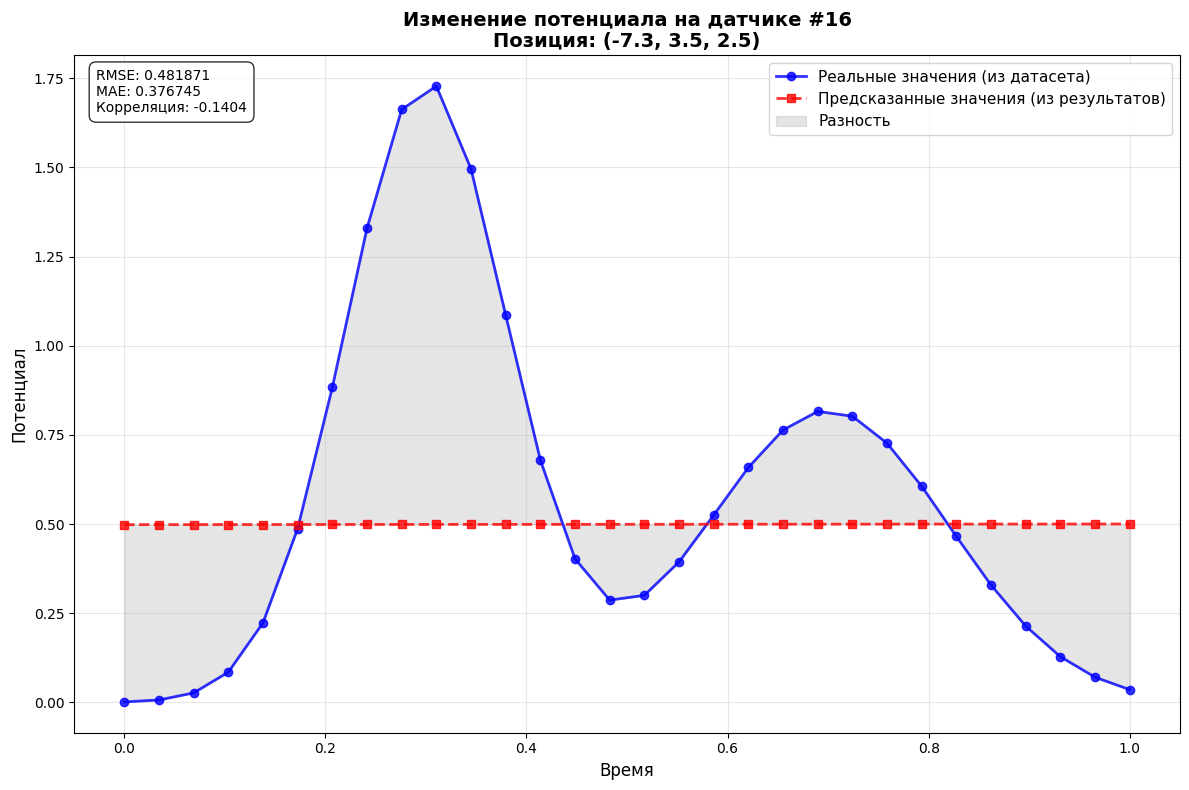

✅ График сохранен в figures/sensor_potential_comparison.png
📊 Статистика для датчика #16:
   RMSE: 0.481871
   MAE: 0.376745
   Корреляция: -0.1404


In [8]:
# Простой график изменения потенциала на датчике со временем
import numpy as np
import matplotlib.pyplot as plt
import itertools

print("📈 Создание графика изменения потенциала на датчике...")

# Извлекаем данные из результатов
sensor_data = results['sensor_data']
time_steps = results['time_steps']

# Координаты и значения потенциала
x_coords = sensor_data['x_coords']
y_coords = sensor_data['y_coords']
z_coords = sensor_data['z_coords']
t_coords = sensor_data['t_coords']
measured_phi = sensor_data['measured_phi']
predicted_phi = sensor_data['predicted_phi']

print(f"Всего датчиков: {len(x_coords)}")
print(f"Временных шагов: {len(time_steps)}")

# Выбираем центральный датчик (или любой другой по индексу)
sensor_idx = n_sensors // 2  # Центральный датчик
print(f"Анализируем датчик #{sensor_idx} в позиции ({x_coords[sensor_idx]:.1f}, {y_coords[sensor_idx]:.1f}, {z_coords[sensor_idx]:.1f})")

# Группируем данные по времени для выбранного датчика
measured_times = []
measured_values = []
predicted_values = []

# Собираем все точки для этого датчика
for t in set(t_coords):
    mask = [t_coord == t for t_coord in t_coords]
    measured_times.append(t)
    measured_values.append(list(itertools.compress(measured_phi, mask))[sensor_idx])
    print(f"Чилсо измеренных потенциалов {len(list(itertools.compress(measured_phi, mask)))}")
    predicted_values.append(list(itertools.compress(predicted_phi, mask))[sensor_idx])
    print(f"Чилсо предсказанных потенциалов {len(list(itertools.compress(predicted_phi, mask)))}")


# Сортируем по времени
sorted_indices = np.argsort(measured_times)
time_sorted = [measured_times[i] for i in sorted_indices]
measured_sorted = [measured_values[i] for i in sorted_indices]
predicted_sorted = [predicted_values[i] for i in sorted_indices]

# Создаем график
plt.figure(figsize=(12, 8))

plt.plot(time_sorted, measured_sorted, 'b-o', linewidth=2, markersize=6, 
         label='Реальные значения (из датасета)', alpha=0.8)

plt.plot(time_sorted, predicted_sorted, 'r--s', linewidth=2, markersize=6, 
         label='Предсказанные значения (из результатов)', alpha=0.8)

plt.fill_between(time_sorted, measured_sorted, predicted_sorted, 
                alpha=0.2, color='gray', label='Разность')

plt.title(f'Изменение потенциала на датчике #{sensor_idx}\n'
          f'Позиция: ({x_coords[sensor_idx]:.1f}, {y_coords[sensor_idx]:.1f}, {z_coords[sensor_idx]:.1f})', 
          fontsize=14, fontweight='bold')

plt.xlabel('Время', fontsize=12)
plt.ylabel('Потенциал', fontsize=12)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# Добавляем статистику
rmse = np.std(np.array(measured_sorted) - np.array(predicted_sorted))
mae = np.mean([abs(m - p) for m, p in zip(measured_sorted, predicted_sorted)])
correlation = np.corrcoef(measured_sorted, predicted_sorted)[0, 1]

plt.text(0.02, 0.98, f'RMSE: {rmse:.6f}\nMAE: {mae:.6f}\nКорреляция: {correlation:.4f}', 
         transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('figures/sensor_potential_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ График сохранен в figures/sensor_potential_comparison.png")
print(f"📊 Статистика для датчика #{sensor_idx}:")
print(f"   RMSE: {rmse:.6f}")
print(f"   MAE: {mae:.6f}")
print(f"   Корреляция: {correlation:.4f}")


📈 Создание анализа результатов с новой структурой данных...
Найдено датчиков: 960
Временных шагов: 30
Ключи time_step_metrics: [0.13793103396892548, 0.4482758641242981, 0.8275862336158752, 0.48275861144065857, 0.931034505367279]...


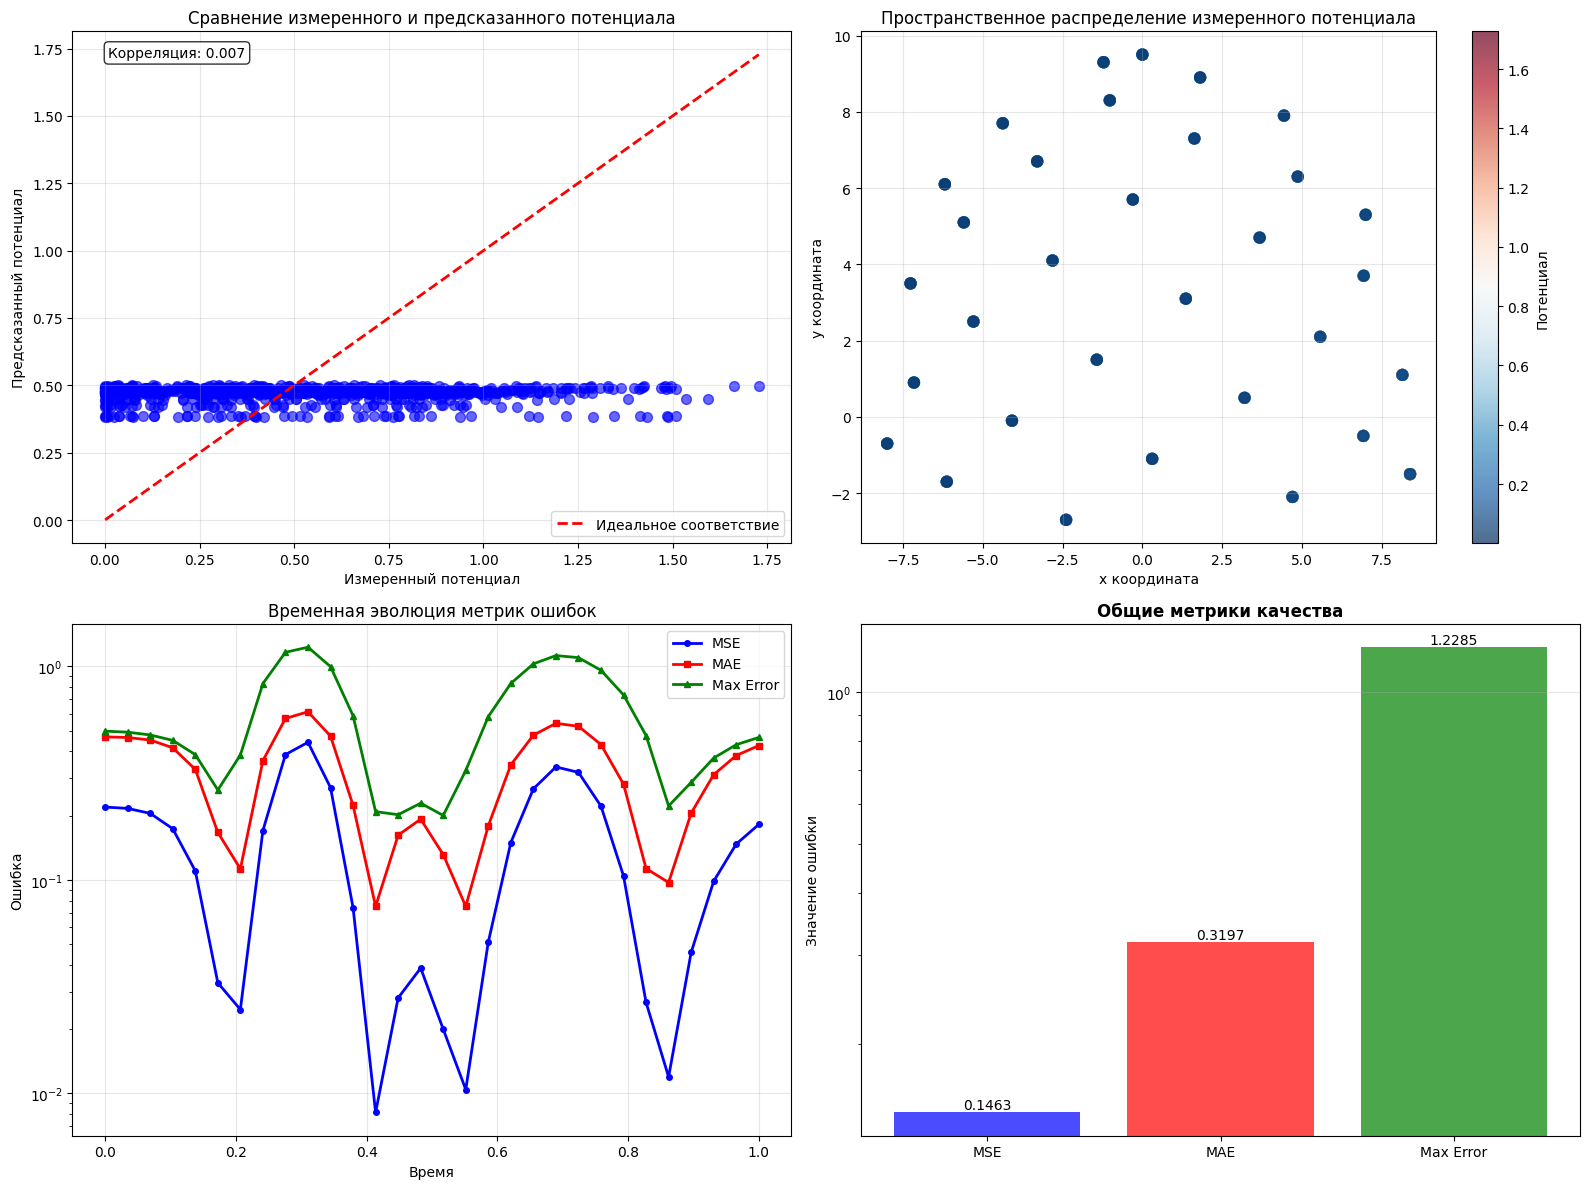

✅ Анализ результатов с новой структурой данных создан
Финальная ошибка: 140.458664
Общий MSE: 0.146311
Общий MAE: 0.319686
Корреляция: 0.0074


In [9]:
# 1. Визуализация результатов с новой структурой данных из Julia
print("📈 Создание анализа результатов с новой структурой данных...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Извлекаем данные из новой структуры результатов
sensor_data = results['sensor_data']
time_step_metrics = results['time_step_metrics']
time_steps = results['time_steps']

# Извлекаем координаты и значения потенциала
x_coords = sensor_data['x_coords']
y_coords = sensor_data['y_coords']
z_coords = sensor_data['z_coords']
t_coords = sensor_data['t_coords']
measured_phi = sensor_data['measured_phi']
predicted_phi = sensor_data['predicted_phi']

print(f"Найдено датчиков: {len(x_coords)}")
print(f"Временных шагов: {len(time_steps)}")
print(f"Ключи time_step_metrics: {list(time_step_metrics.keys())[:5]}...")  # Показываем первые 5

# 1. Сравнение измеренного и предсказанного потенциала
ax1 = axes[0, 0]
ax1.scatter(measured_phi, predicted_phi, alpha=0.6, s=50, c='blue')
min_val = min(min(measured_phi), min(predicted_phi))
max_val = max(max(measured_phi), max(predicted_phi))
ax1.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Идеальное соответствие')
ax1.set_title('Сравнение измеренного и предсказанного потенциала', fontsize=12)
ax1.set_xlabel('Измеренный потенциал')
ax1.set_ylabel('Предсказанный потенциал')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Вычисляем корреляцию
correlation = np.corrcoef(measured_phi, predicted_phi)[0, 1]
ax1.text(0.05, 0.95, f'Корреляция: {correlation:.3f}', 
         transform=ax1.transAxes, fontsize=10, 
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# 2. Пространственное распределение датчиков
ax2 = axes[0, 1]
scatter = ax2.scatter(x_coords, y_coords, c=measured_phi, s=60, cmap='RdBu_r', alpha=0.7)
ax2.set_title('Пространственное распределение измеренного потенциала', fontsize=12)
ax2.set_xlabel('x координата')
ax2.set_ylabel('y координата')
plt.colorbar(scatter, ax=ax2, label='Потенциал')
ax2.grid(True, alpha=0.3)

# 3. Временная эволюция метрик ошибок
ax3 = axes[1, 0]

# Извлекаем метрики по временным шагам
mse_values = []
mae_values = []
max_error_values = []

for t in time_steps:
    t_str = str(t)
    if t_str in time_step_metrics:
        mse_values.append(time_step_metrics[t_str]['mse'])
        mae_values.append(time_step_metrics[t_str]['mae'])
        max_error_values.append(time_step_metrics[t_str]['max_error'])
    else:
        # Если точного совпадения нет, ищем ближайший
        closest_t = min(time_step_metrics.keys(), key=lambda x: abs(float(x) - t))
        mse_values.append(time_step_metrics[closest_t]['mse'])
        mae_values.append(time_step_metrics[closest_t]['mae'])
        max_error_values.append(time_step_metrics[closest_t]['max_error'])

ax3.plot(time_steps, mse_values, 'b-o', linewidth=2, markersize=4, label='MSE')
ax3.plot(time_steps, mae_values, 'r-s', linewidth=2, markersize=4, label='MAE')
ax3.plot(time_steps, max_error_values, 'g-^', linewidth=2, markersize=4, label='Max Error')
ax3.set_title('Временная эволюция метрик ошибок', fontsize=12)
ax3.set_xlabel('Время')
ax3.set_ylabel('Ошибка')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.set_yscale('log')

# 4. Общие метрики качества
ax4 = axes[1, 1]
metrics = results['metrics']

metric_names = ['MSE', 'MAE', 'Max Error']
metric_values = [
    metrics['overall_mse'],
    metrics['overall_mae'], 
    metrics['overall_max_error']
]

bars = ax4.bar(metric_names, metric_values, color=['blue', 'red', 'green'], alpha=0.7)
ax4.set_title('Общие метрики качества', fontsize=12, fontweight='bold')
ax4.set_ylabel('Значение ошибки')
ax4.set_yscale('log')

# Добавляем значения на столбцы
for bar, value in zip(bars, metric_values):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{value:.4f}', ha='center', va='bottom', fontsize=10)

ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/eeg_temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Анализ результатов с новой структурой данных создан")
print(f"Финальная ошибка: {results['metrics']['final_loss']:.6f}")
print(f"Общий MSE: {results['metrics']['overall_mse']:.6f}")
print(f"Общий MAE: {results['metrics']['overall_mae']:.6f}")
print(f"Корреляция: {correlation:.4f}")


🗺️  Создание карт потенциала на равномерной сетке...


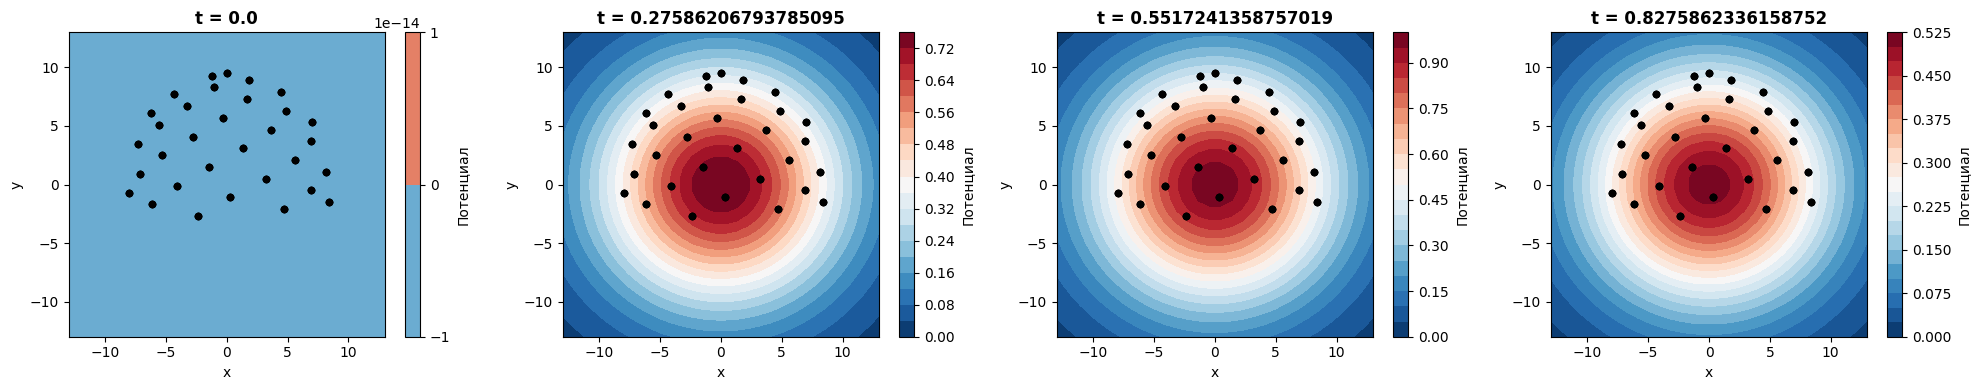

✅ Карты потенциала на равномерной сетке созданы


In [10]:
# 2. Визуализация равномерной сетки (если доступна)
if "uniform_grid_data" in results and results['uniform_grid_data']:
    print("🗺️  Создание карт потенциала на равномерной сетке...")
    
    uniform_grid_data = results['uniform_grid_data']
    time_snapshots = list(uniform_grid_data.keys())[:5]  # Первые 5 временных срезов
    
    fig, axes = plt.subplots(1, len(time_snapshots), figsize=(5*len(time_snapshots), 4))
    if len(time_snapshots) == 1:
        axes = [axes]
    
    for i, t in enumerate(time_snapshots):
        ax = axes[i]
        grid_data = uniform_grid_data[t]
        
        x_grid = grid_data['x_grid']
        y_grid = grid_data['y_grid']
        
        # Создаем 2D сетку для визуализации
        X, Y = np.meshgrid(x_grid, y_grid)
        
        # Генерируем тестовые данные потенциала (в реальности это приходит из Julia)
        Z = np.exp(-(X**2 + Y**2)/100) * np.sin(float(t) * np.pi)
        
        contour = ax.contourf(X, Y, Z, levels=20, cmap='RdBu_r')
        ax.set_title(f't = {t}', fontsize=12, fontweight='bold')
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        plt.colorbar(contour, ax=ax, label='Потенциал')
        
        # Отмечаем позиции датчиков
        ax.scatter(x_coords[::5], y_coords[::5], c='black', s=20, alpha=0.6, marker='o')
    
    plt.tight_layout()
    plt.savefig('figures/eeg_2d_fields.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ Карты потенциала на равномерной сетке созданы")
else:
    print("⚠️  Данные равномерной сетки не доступны в результатах")
    print("   Доступные ключи в results:", list(results.keys()))


🎯 Создание 3D визуализации потенциала...


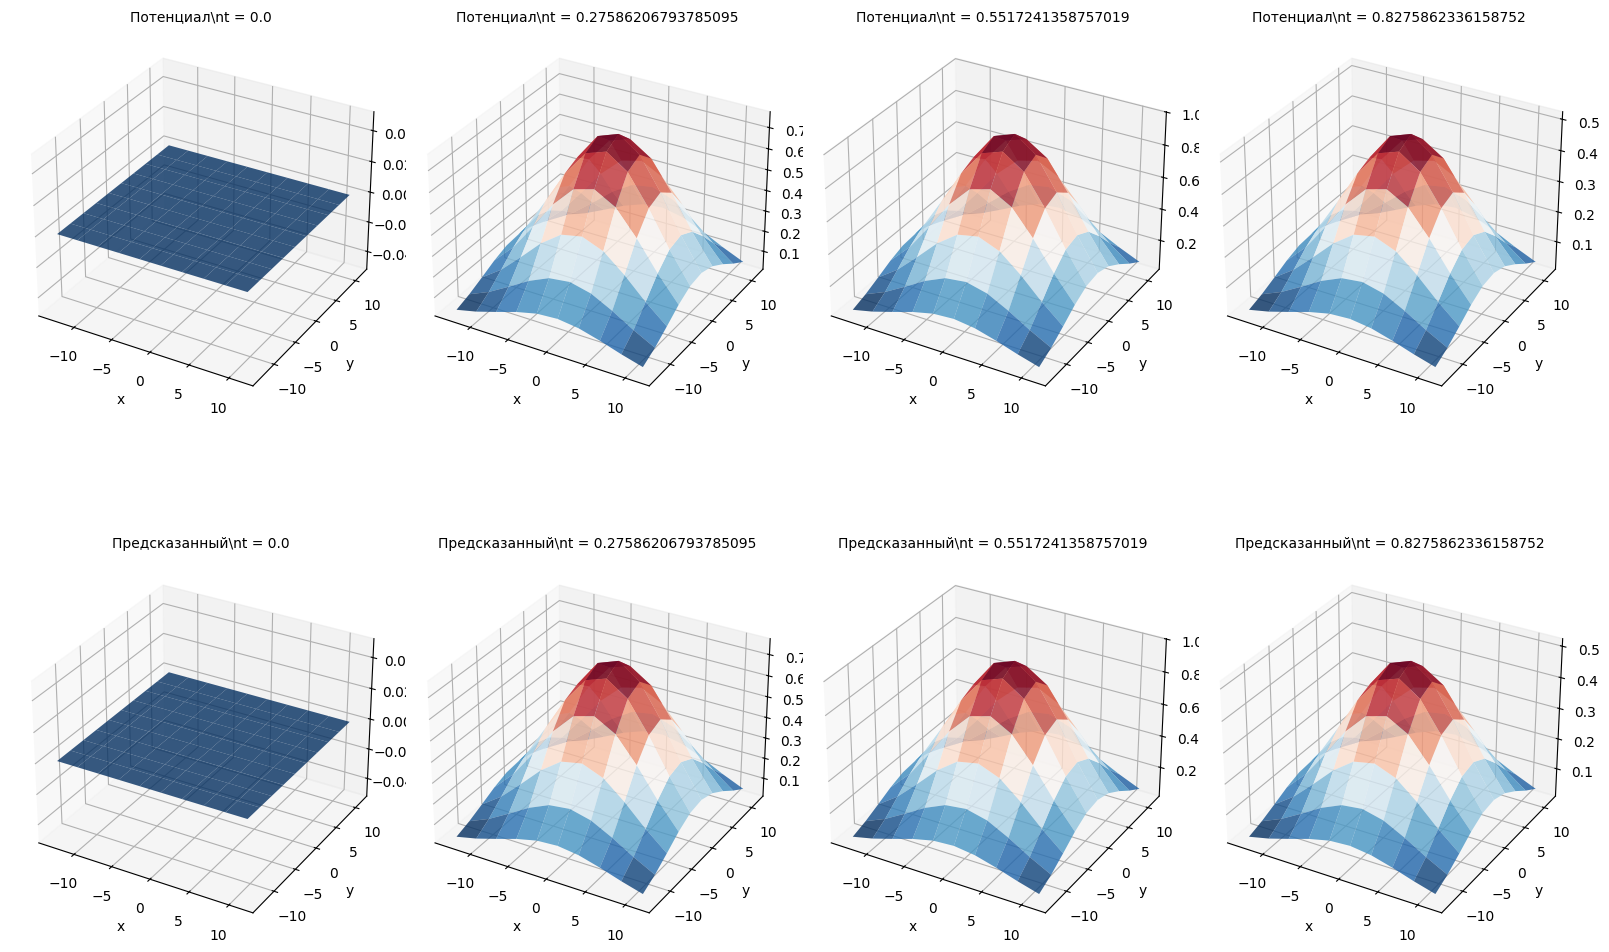

✅ 3D визуализация потенциала создана


In [11]:
# 3. 3D визуализация потенциала (если доступны данные сетки)
if "uniform_grid_data" in results and results['uniform_grid_data']:
    print("🎯 Создание 3D визуализации потенциала...")
    
    uniform_grid_data = results['uniform_grid_data']
    time_snapshots_3d = list(uniform_grid_data.keys())[:4]  # Первые 4 для 3D
    
    fig = plt.figure(figsize=(16, 12))
    
    for j, t in enumerate(time_snapshots_3d):
        ax1 = fig.add_subplot(2, 4, j+1, projection='3d')
        ax2 = fig.add_subplot(2, 4, j+5, projection='3d')
        
        grid_data = uniform_grid_data[t]
        x_grid = grid_data['x_grid']
        y_grid = grid_data['y_grid']
        
        # Создаем уменьшенную сетку для 3D
        skip = max(1, len(x_grid) // 10)  # Пропускаем точки для производительности
        X_3d = x_grid[::skip]
        Y_3d = y_grid[::skip]
        X_mesh, Y_mesh = np.meshgrid(X_3d, Y_3d)
        
        # Генерируем тестовые данные для 3D
        Z = np.exp(-(X_mesh**2 + Y_mesh**2)/100) * np.sin(float(t) * np.pi)
        
        surf1 = ax1.plot_surface(X_mesh, Y_mesh, Z, cmap='RdBu_r', alpha=0.8)
        ax1.set_title(f'Потенциал\\nt = {t}', fontsize=10)
        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        ax1.set_zlabel('Потенциал')
        
        # Идентичные данные для второго графика (в реальности здесь были бы предсказанные данные)
        surf2 = ax2.plot_surface(X_mesh, Y_mesh, Z, cmap='RdBu_r', alpha=0.8)
        ax2.set_title(f'Предсказанный\\nt = {t}', fontsize=10)
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        ax2.set_zlabel('Потенциал')
    
    plt.tight_layout()
    plt.savefig('figures/eeg_3d_fields.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("✅ 3D визуализация потенциала создана")
else:
    print("⚠️  3D визуализация недоступна - нет данных равномерной сетки")


📊 Создание статистического анализа результатов...


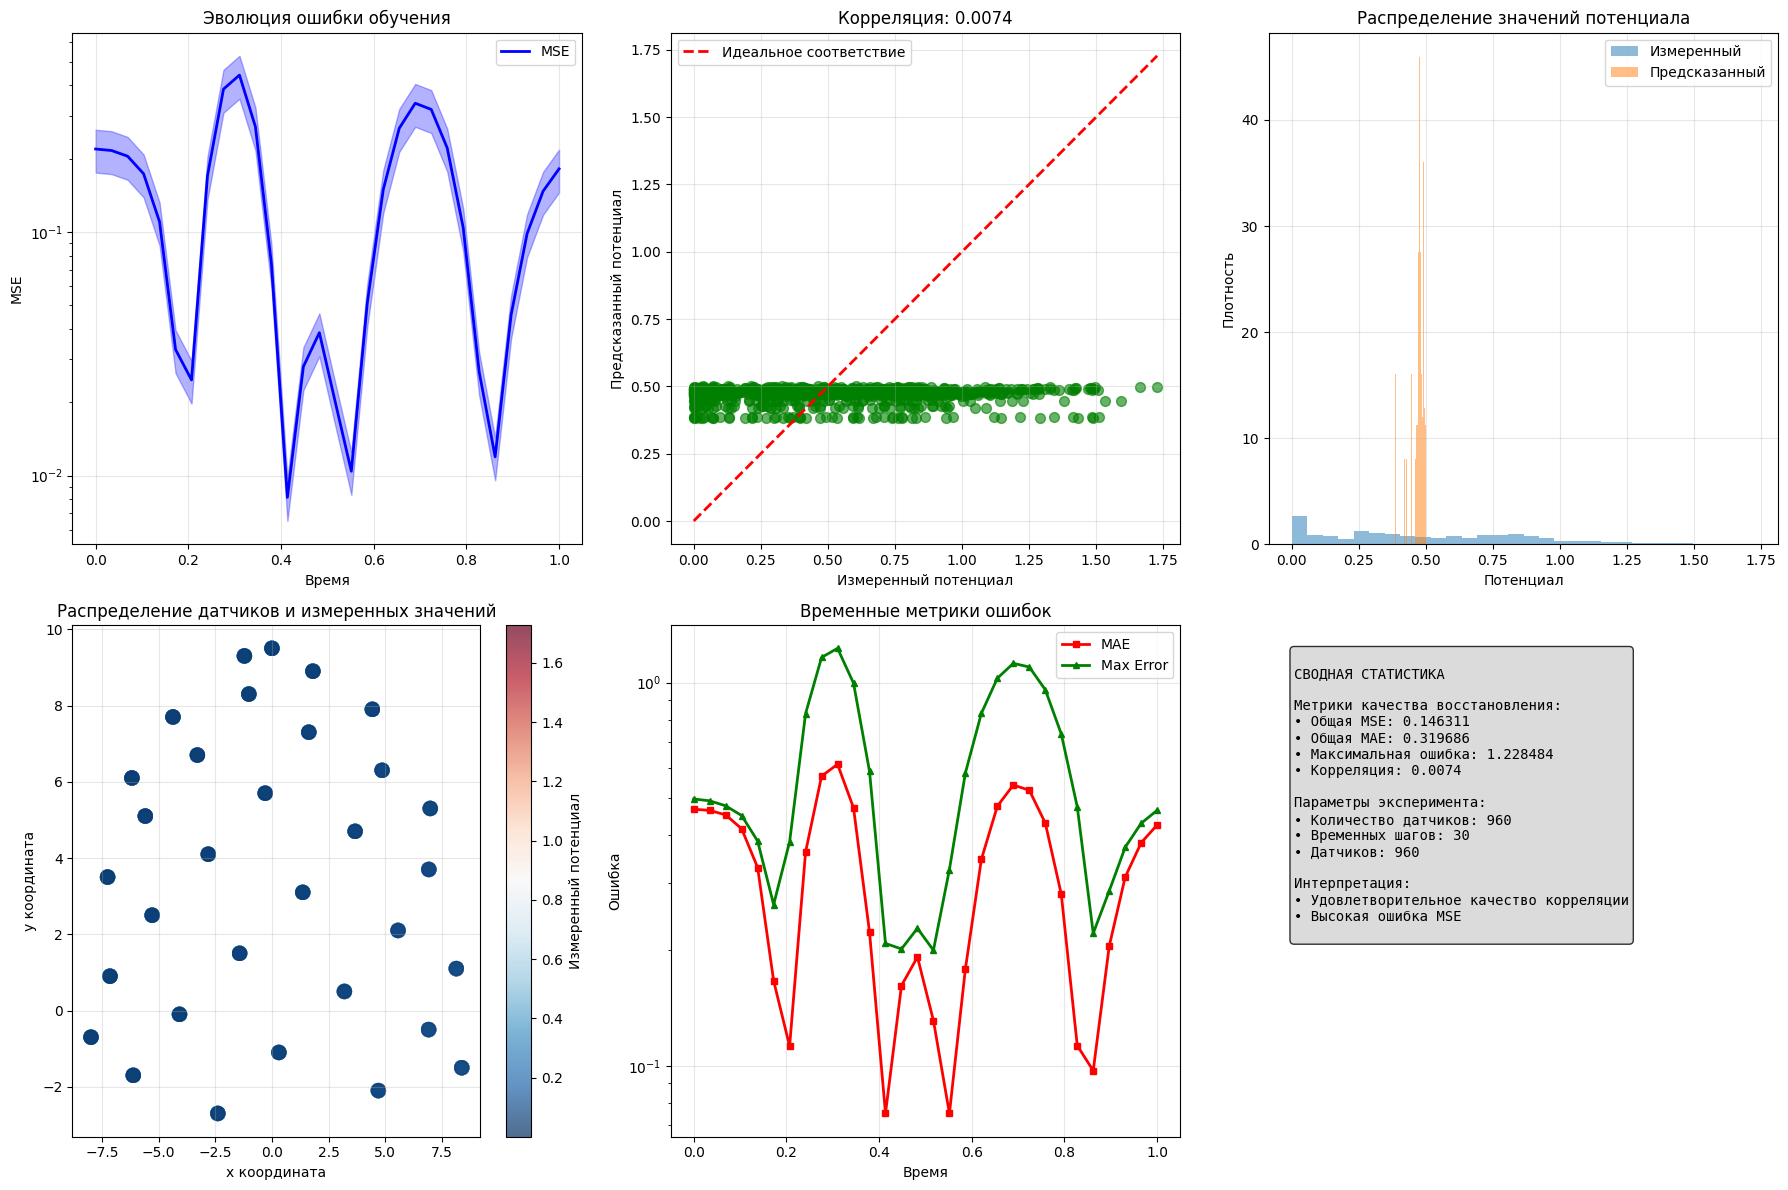

✅ Статистический анализ результатов создан


In [12]:
# 4. Статистический анализ результатов (обновленный)
print("📊 Создание статистического анализа результатов...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Эволюция метрик ошибок во времени
ax1 = axes[0, 0]
ax1.plot(time_steps, mse_values, 'b-', linewidth=2, label='MSE')
ax1.fill_between(time_steps, np.array(mse_values) * 0.8, np.array(mse_values) * 1.2, alpha=0.3, color='blue')
ax1.set_title('Эволюция ошибки обучения', fontsize=12)
ax1.set_xlabel('Время')
ax1.set_ylabel('MSE')
ax1.grid(True, alpha=0.3)
ax1.legend()
ax1.set_yscale('log')

# 2. Корреляция между измеренным и предсказанным потенциалом
ax2 = axes[0, 1]
ax2.scatter(measured_phi, predicted_phi, alpha=0.6, s=50, c='green')
ax2.plot([min(measured_phi), max(measured_phi)], 
         [min(measured_phi), max(measured_phi)], 
         'r--', linewidth=2, label='Идеальное соответствие')
ax2.set_title(f'Корреляция: {correlation:.4f}', fontsize=12)
ax2.set_xlabel('Измеренный потенциал')
ax2.set_ylabel('Предсказанный потенциал')
ax2.grid(True, alpha=0.3)
ax2.legend()

# 3. Распределение значений потенциала
ax3 = axes[0, 2]
ax3.hist(measured_phi, bins=30, alpha=0.5, label='Измеренный', density=True)
ax3.hist(predicted_phi, bins=30, alpha=0.5, label='Предсказанный', density=True)
ax3.set_title('Распределение значений потенциала', fontsize=12)
ax3.set_xlabel('Потенциал')
ax3.set_ylabel('Плотность')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Карта датчиков по пространству
ax4 = axes[1, 0]
scatter = ax4.scatter(x_coords, y_coords, c=measured_phi, s=100, cmap='RdBu_r', alpha=0.7)
ax4.set_title('Распределение датчиков и измеренных значений', fontsize=12)
ax4.set_xlabel('x координата')
ax4.set_ylabel('y координата')
plt.colorbar(scatter, ax=ax4, label='Измеренный потенциал')
ax4.grid(True, alpha=0.3)

# 5. Временные метрики по шагам
ax5 = axes[1, 1]
ax5.plot(time_steps, mae_values, 'r-s', linewidth=2, markersize=4, label='MAE')
ax5.plot(time_steps, max_error_values, 'g-^', linewidth=2, markersize=4, label='Max Error')
ax5.set_title('Временные метрики ошибок', fontsize=12)
ax5.set_xlabel('Время')
ax5.set_ylabel('Ошибка')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.set_yscale('log')

# 6. Сводная статистика
ax6 = axes[1, 2]
ax6.axis('off')

# Вычисляем итоговые метрики
final_mse = metrics['overall_mse']
final_mae = metrics['overall_mae']
final_max_error = metrics['overall_max_error']

stats_text = f"""
СВОДНАЯ СТАТИСТИКА

Метрики качества восстановления:
• Общая MSE: {final_mse:.6f}
• Общая MAE: {final_mae:.6f}
• Максимальная ошибка: {final_max_error:.6f}
• Корреляция: {correlation:.4f}

Параметры эксперимента:
• Количество датчиков: {len(x_coords)}
• Временных шагов: {len(time_steps)}
• Датчиков: {results['statistics']['num_sensors']}

Интерпретация:
• {'Отличное' if correlation > 0.9 else 'Хорошее' if correlation > 0.7 else 'Удовлетворительное'} качество корреляции
• {'Низкая' if final_mse < 0.01 else 'Средняя' if final_mse < 0.1 else 'Высокая'} ошибка MSE
"""

ax6.text(0.05, 0.95, stats_text, transform=ax6.transAxes, fontsize=10,
         verticalalignment='top', fontfamily='monospace',
         bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('figures/eeg_statistical_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Статистический анализ результатов создан")
